<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/09_pomdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division
from IPython.core import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# If you are running on a server, launch xvfb to record game videos
# Please make sure you have xvfb installed
import os
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfbstart-stop-daemon: unable to stat /usr/bin/Xvfb (No such file or directory)
.


### 环境：KungFuMaster

In [0]:
import numpy as np
from gym.core import Wrapper
from gym.spaces.box import Box
from skimage.transform import resize


class PreprocessAtari(Wrapper):
    def __init__(self, env, height=42, width=42, color=False,
                 crop=lambda img: img, n_frames=4, dim_order='theano'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(PreprocessAtari, self).__init__(env)
        assert dim_order in ('theano', 'tensorflow')
        self.img_size = (height, width)
        self.crop = crop
        self.color = color
        self.dim_order = dim_order

        n_channels = (3 * n_frames) if color else n_frames
        obs_shape = \
            [n_channels, height, width] \
            if dim_order == 'theano' else \
            [height, width, n_channels]
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, r, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, r, done, info

    ### image processing ###

    def update_buffer(self, img):
        img = self.preproc_image(img)
        offset = 3 if self.color else 1
        if self.dim_order == 'theano':
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        else:
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)

    def preproc_image(self, img):
        """what happens to the observation"""
        img = self.crop(img)
        img = resize(img, self.img_size)
        if not self.color:
            img = img.mean(-1, keepdims=True)
        if self.dim_order == 'theano':
            img = img.transpose([2, 0, 1])  # [h, w, c] to [c, h, w]
        img = img.astype('float32') / 255.
        return img

In [3]:
import gym

def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(env, height=42, width=42,
                          crop=lambda img: img[60:-30, 15:],
                          dim_order='tensorflow',
                          color=False, n_frames=1)
    return env


env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (42, 42, 1)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


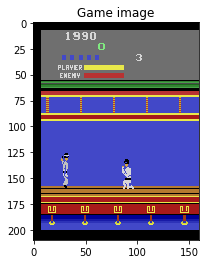

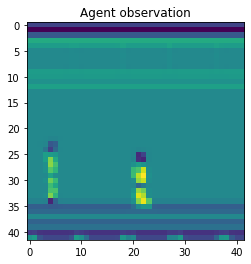

In [4]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation')
plt.imshow(s.reshape([42, 42]))
plt.show()


### Simple agent for fully-observable MDP

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,Flatten
tf.reset_default_graph()
sess = tf.InteractiveSession()
class FeedforwardAgent:
    def __init__(self, name, obs_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""

        with tf.variable_scope(name, reuse=reuse):
            # Note: number of units/filters is arbitrary, you can and should change it at your will
            self.conv0 = Conv2D(32, (3, 3), strides=(2, 2), activation='elu')
            self.conv1 = Conv2D(32, (3, 3), strides=(2, 2), activation='elu')
            self.conv2 = Conv2D(32, (3, 3), strides=(2, 2), activation='elu')
            self.flatten = Flatten()
            self.hid = Dense(128, activation='elu')
            self.logits = Dense(n_actions)
            self.state_value = Dense(1)

            # prepare a graph for agent step
            _initial_state = self.get_initial_state(1)
            self.prev_state_placeholders = [tf.placeholder(m.dtype,
                                                           [None] + [m.shape[i] for i in range(1, m.ndim)])
                                            for m in _initial_state]
            self.obs_t = tf.placeholder('float32', [None, ] + list(obs_shape))
            self.next_state, self.agent_outputs = self.symbolic_step(
                self.prev_state_placeholders, self.obs_t)
    def symbolic_step(self, prev_state, obs_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""

        nn = self.conv0(obs_t)
        nn = self.conv1(nn)
        nn = self.conv2(nn)
        nn = self.flatten(nn)
        nn = self.hid(nn)
        logits = self.logits(nn)
        state_value = self.state_value(nn)

        # feedforward agent has no state
        new_state = []

        return new_state, (logits, state_value)

    def get_initial_state(self, batch_size):
        """Return a list of agent memory states at game start. Each state is a np array of shape [batch_size, ...]"""
        # feedforward agent has no state
        return []

    def step(self, prev_state, obs_t):
        """Same as symbolic state except it operates on numpy arrays"""
        sess = tf.get_default_session()
        feed_dict = {self.obs_t: obs_t}
        for state_ph, state_value in zip(self.prev_state_placeholders, prev_state):
            feed_dict[state_ph] = state_value
        return sess.run([self.next_state, self.agent_outputs], feed_dict)

    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits),
                                         axis=-1, keepdims=True)
        return [np.random.choice(len(p), p=p) for p in policy]

In [6]:
n_parallel_games = 5
gamma = 0.99

agent = FeedforwardAgent("agent", obs_shape, n_actions)

sess.run(tf.global_variables_initializer())

state = [env.reset()]
_, (logits, value) = agent.step(agent.get_initial_state(1), state)
print("action logits:\n", logits)
print("state values:\n", value)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
action logits:
 [[ 1.0684046e-03  8.6777880e-05 -6.8907929e-04  3.9314822e-04
   1.1070127e-03 -5.1187153e-04 -1.5082303e-04  3.7666113e-04
   7.3291018e-04  7.1290997e-04 -6.4894697e-04 -2.5004349e-04
   8.5986970e-04 -4.3272407e-04]]
state values:
 [[-0.00074987]]


### 开始训练

In [0]:
def evaluate(agent, env, n_games=1):
    """Plays an entire game start to end, returns session rewards."""

    game_rewards = []
    for _ in range(n_games):
        # initial observation and memory
        observation = env.reset()
        prev_memories = agent.get_initial_state(1)

        total_reward = 0
        while True:
            new_memories, readouts = agent.step(
                prev_memories, observation[None, ...])
            action = agent.sample_actions(readouts)

            observation, reward, done, info = env.step(action[0])

            total_reward += reward
            prev_memories = new_memories
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

In [8]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print(rw)

[200.0, 200.0, 400.0]


In [9]:
# show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s: s.endswith(
    ".mp4"), os.listdir("./kungfu_videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

### 并行训练

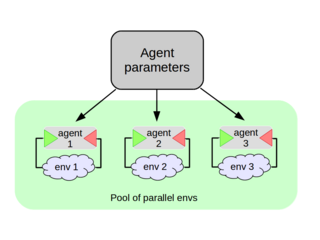

In [0]:
import numpy as np

# A whole lot of space invaders


class EnvPool(object):
    def __init__(self, agent, make_env, n_parallel_games=1):
        """
        A special class that handles training on multiple parallel sessions
        and is capable of some auxilary actions like evaluating agent on one game session (See .evaluate()).
        :param agent: Agent which interacts with the environment.
        :param make_env: Factory that produces environments OR a name of the gym environment.
        :param n_games: Number of parallel games. One game by default.
        :param max_size: Max pool size by default (if appending sessions). By default, pool is not constrained in size.
        """
        # Create atari games.
        self.agent = agent
        self.make_env = make_env
        self.envs = [self.make_env() for _ in range(n_parallel_games)]

        # Initial observations.
        self.prev_observations = [env.reset() for env in self.envs]

        # Agent memory variables (if you use recurrent networks).
        self.prev_memory_states = agent.get_initial_state(n_parallel_games)

        # Whether particular session has just been terminated and needs
        # restarting.
        self.just_ended = [False] * len(self.envs)

    def interact(self, n_steps=100, verbose=False):
        """Generate interaction sessions with ataries (openAI gym atari environments)
        Sessions will have length n_steps. Each time one of games is finished, it is immediately getting reset
        and this time is recorded in is_alive_log (See returned values).
        :param n_steps: Length of an interaction.
        :returns: observation_seq, action_seq, reward_seq, is_alive_seq
        :rtype: a bunch of tensors [batch, tick, ...]
        """

        def env_step(i, action):
            if not self.just_ended[i]:
                new_observation, cur_reward, is_done, info = \
                    self.envs[i].step(action)
                if is_done:
                    # Game ends now, will finalize on next tick.
                    self.just_ended[i] = True

                # note: is_alive=True in any case because environment is still
                # alive (last tick alive) in our notation.
                return new_observation, cur_reward, True, info
            else:
                # Reset environment, get new observation to be used on next
                # tick.
                new_observation = self.envs[i].reset()

                # Reset memory for new episode.
                initial_memory_state = self.agent.get_initial_state(
                    batch_size=1)
                for m_i in range(len(new_memory_states)):
                    new_memory_states[m_i][i] = initial_memory_state[m_i][0]

                if verbose:
                    print("env %i reloaded" % i)

                self.just_ended[i] = False

                return new_observation, 0, False, {'end': True}

        history_log = []

        for i in range(n_steps - 1):
            new_memory_states, readout = self.agent.step(
                self.prev_memory_states, self.prev_observations)
            actions = self.agent.sample_actions(readout)

            new_observations, cur_rewards, is_alive, infos = zip(
                *map(env_step, range(len(self.envs)), actions))

            # Append data tuple for this tick.
            history_log.append(
                (self.prev_observations, actions, cur_rewards, is_alive))

            self.prev_observations = new_observations
            self.prev_memory_states = new_memory_states

        # add last observation
        dummy_actions = [0] * len(self.envs)
        dummy_rewards = [0] * len(self.envs)
        dummy_mask = [1] * len(self.envs)
        history_log.append(
            (self.prev_observations,
             dummy_actions,
             dummy_rewards,
             dummy_mask))

        # cast to numpy arrays, transpose from [time, batch, ...] to [batch,
        # time, ...]
        history_log = [
            np.array(tensor).swapaxes(0, 1)
            for tensor in zip(*history_log)
        ]
        observation_seq, action_seq, reward_seq, is_alive_seq = history_log

        return observation_seq, action_seq, reward_seq, is_alive_seq

In [11]:

pool = EnvPool(agent, make_env, n_parallel_games)
#for each of n_parallel_games, take 10 steps
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)
print("Actions shape:", rollout_actions.shape)
print("Rewards shape:", rollout_rewards.shape)
print("Mask shape:", rollout_mask.shape)
print("Observations shape: ", rollout_obs.shape)

Actions shape: (5, 10)
Rewards shape: (5, 10)
Mask shape: (5, 10)
Observations shape:  (5, 10, 42, 42, 1)


### Actor-critic

In [0]:
observations_ph = tf.placeholder('float32', [None, None, ] + list(obs_shape))
actions_ph = tf.placeholder('int32', (None, None,))
rewards_ph = tf.placeholder('float32', (None, None,))
mask_ph = tf.placeholder('float32', (None, None,))

initial_memory_ph = agent.prev_state_placeholders
dummy_outputs = agent.symbolic_step(
    initial_memory_ph, observations_ph[:, 0])[1]

_, outputs_seq = tf.scan(
    lambda stack, obs_t: agent.symbolic_step(stack[0], obs_t),
    initializer=(initial_memory_ph, dummy_outputs),
    # [time, batch, h, w, c]
    elems=tf.transpose(observations_ph, [1, 0, 2, 3, 4])
)

# from [time, batch] back to [batch, time]
outputs_seq = [tf.transpose(
    tensor, [1, 0] + list(range(2, tensor.shape.ndims))) for tensor in outputs_seq]

In [14]:
# actor-critic losses
# logits shape: [batch, time, n_actions], states shape: [batch, time, n_actions]
logits_seq, state_values_seq = outputs_seq

logprobs_seq = tf.nn.log_softmax(logits_seq)
logp_actions = tf.reduce_sum(
    logprobs_seq * tf.one_hot(actions_ph, n_actions), axis=-1)[:, :-1]

current_rewards = rewards_ph[:, :-1] / 100.
current_state_values = state_values_seq[:, :-1, 0]
next_state_values = state_values_seq[:, 1:, 0] * mask_ph[:, :-1]

# policy gradient
# compute 1-step advantage using current_rewards, current_state_values and next_state_values
advantage =  # YOUR CODE
assert advantage.shape.ndims == 2
# compute policy entropy given logits_seq. Mind the sign!
entropy =  # YOUR CODE
assert entropy.shape.ndims == 2

actor_loss = - tf.reduce_mean(logp_actions * tf.stop_gradient(advantage)) - 1e-2 * tf.reduce_mean(entropy)

# compute target qvalues using temporal difference
target_qvalues =  # YOUR CODE
critic_loss = tf.reduce_mean(
    (current_state_values - tf.stop_gradient(target_qvalues))**2)

train_step = tf.train.AdamOptimizer(1e-5).minimize(actor_loss + critic_loss)

SyntaxError: ignored

In [0]:
sess.run(tf.global_variables_initializer())


### Train
just run train step and see if agent learns any better

In [0]:
def sample_batch(rollout_length=10):
    prev_mem = pool.prev_memory_states
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(
        rollout_length)

    feed_dict = {
        observations_ph: rollout_obs,
        actions_ph: rollout_actions,
        rewards_ph: rollout_rewards,
        mask_ph: rollout_mask,
    }
    for placeholder, value in zip(initial_memory_ph, prev_mem):
        feed_dict[placeholder] = value
    return feed_dict

from IPython.display import clear_output
from tqdm import trange
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

rewards_history = []



In [0]:
for i in trange(5000):
    sess.run(train_step, sample_batch())

    if i % 100 == 0:
        rewards_history.append(np.mean(evaluate(agent, env, n_games=1)))
        clear_output(True)
        plt.plot(rewards_history, label='rewards')
        plt.plot(moving_average(np.array(rewards_history),
                                span=10), label='rewards ewma@10')
        plt.legend()
        plt.show()
        if rewards_history[-1] >= 10000:
            print("Your agent has just passed the minimum homework threshold")
            break

### "Final" evaluation

In [0]:
|env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
final_rewards = evaluate(agent, env_monitor, n_games=20,)
env_monitor.close()
print("Final mean reward": np.mean(final_rewards))

video_names = list(filter(lambda s: s.endswith(
    ".mp4"), os.listdir("./kungfu_videos/")))
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices


### POMDP setting
The atari game we're working with is actually a POMDP: your agent needs to know timing at which enemies spawn and move, but cannot do so unless it has some memory.

Let's design another agent that has a recurrent neural net memory to solve this.

Note: it's also a good idea to scale rollout_len up to learn longer sequences. You may wish set it to >=20 or to start at 10 and then scale up as time passes.

In [0]:
class SimpleRecurrentAgent:
    def __init__(self, name, obs_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""

        with tf.variable_scope(name, reuse=reuse):
            # Note: number of units/filters is arbitrary, you can and should change it at your will
            self.conv0 = Conv2D(32, (3, 3), strides=(2, 2), activation='elu')
            self.conv1 = Conv2D(32, (3, 3), strides=(2, 2), activation='elu')
            self.conv2 = Conv2D(32, (3, 3), strides=(2, 2), activation='elu')
            self.flatten = Flatten()
            self.hid = Dense(128, activation='elu')

            self.rnn0 = tf.nn.rnn_cell.GRUCell(256, activation=tf.tanh)

            self.logits = Dense(n_actions)
            self.state_value = Dense(1)

            # prepare a graph for agent step
            _initial_state = self.get_initial_state(1)
            self.prev_state_placeholders = [tf.placeholder(m.dtype,
                                                           [None] + [m.shape[i] for i in range(1, m.ndim)])
                                            for m in _initial_state]
            self.obs_t = tf.placeholder('float32', [None, ] + list(obs_shape))
            self.next_state, self.agent_outputs = self.symbolic_step(
                self.prev_state_placeholders, self.obs_t)
    def symbolic_step(self, prev_state, obs_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""

        nn = self.conv0(obs_t)
        nn = self.conv1(nn)
        nn = self.conv2(nn)
        nn = self.flatten(nn)
        nn = self.hid(nn)

        (prev_rnn0,) = prev_state

        # YOUR CODE: apply recurrent neural net for one step here.
        # See docs on self.rnn0(...)
        # the recurrent cell should take the last feedforward dense layer as input
        raise NotImplementedError("Please implement rnn step")

        logits = self.logits( < some layer > )
        state_value = self.state_value( < some layer > )

        new_state = [new_rnn0]

        return new_state, (logits, state_value)

    def get_initial_state(self, batch_size):
        """Return a list of agent memory states at game start. Each state is a np array of shape [batch_size, ...]"""
        # feedforward agent has no state
        return [np.zeros([batch_size, self.rnn0.output_size], 'float32')]

    def step(self, prev_state, obs_t):
        """Same as symbolic state except it operates on numpy arrays"""
        sess = tf.get_default_session()
        feed_dict = {self.obs_t: obs_t}
        for state_ph, state_value in zip(self.prev_state_placeholders, prev_state):
            feed_dict[state_ph] = state_value
        return sess.run([self.next_state, self.agent_outputs], feed_dict)

    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits),
                                         axis=-1, keepdims=True)
        return [np.random.choice(len(p), p=p) for p in policy]

SyntaxError: ignored

In [0]:
agent = SimpleRecurrentAgent('agent_with_memory', obs_shape, n_actions)


In [0]:
# A whole lot of your code here: train the new agent with GRU memory.
# - create pool
# - write loss functions and training op
# - train
# You can reuse most of the code with zero to few changes